In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xrft as xrft
import warnings
from glob import glob
import sys
import matplotlib.gridspec as gridspec

sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [3]:
def ogive(deltaf,G):
    '''
    ogive(deltaf,G): use very simple integration to calculate the ogive 
    from a spectrum G with data sampled at frequency deltaf.
    2017-01-10T09:40:31 going back to a single frequency for Os and Gs
    '''
    M1 = len(G)
    Og = np.zeros(M1,float)
    Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
    Og *= deltaf
    Og = np.flipud(Og)
    return Og



In [4]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [5]:
dxx=0.5
dyy=dxx
N2r=2.175e-05

In [6]:
eke_full=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/Eke_full_total.nc')['__xarray_dataarray_variable__']
eke_smth=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/Eke_smth_total.nc')['__xarray_dataarray_variable__']

n2_full=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_full_total.nc')
n2_smth=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_smth_total.nc')

B_full=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/B_full_total.nc')['__xarray_dataarray_variable__'] #multiply by N2r before
B_smth=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/B_smth_total.nc')['__xarray_dataarray_variable__']

wb_full=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/wb_full_*.nc',data_vars='minimal')['__xarray_dataarray_variable__']
wb_smth=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/new_spec/wb_smth_*.nc',data_vars='minimal')['__xarray_dataarray_variable__']

In [7]:
#EPE calculation
n2_compromise=(n2_full.mean(axis=0)+ n2_smth.mean(axis=0))/2

epe_full_new=(1/(2*n2_compromise.data[None,:,None]))*B_full
epe_smth_new=(1/(2*n2_compromise.data[None,:,None]))*B_smth



# Panel 1 - Ogives

In [6]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

#### Loading currents and windstress for windwork

In [7]:
chunks_new={'time_counter':10}

In [8]:
%%time
uf=varf.u
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

ut=vart.u
ut=ut.chunk(chunks=chunks_new);
ut=ut.compute();

vf=varf.v
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();

vt=vart.v
vt=vt.chunk(chunks=chunks_new);
vt=vt.compute();



CPU times: user 12 s, sys: 15.4 s, total: 27.3 s
Wall time: 3min 1s


In [9]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [10]:
%time
usf=varf.sustr
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();


ust=vart.sustr
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();



vsf=varf.svstr
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();


vst=vart.svstr
vst=vst.chunk(chunks=chunks_new);
vst=vst.compute();




CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 12.4 µs


In [11]:
usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [12]:
nfw=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'


with ProgressBar():
    Xf=xrft.isotropic_cross_spectrum(usf,uf,
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yf=xrft.isotropic_cross_spectrum(vsf,vf,
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real


    Xt=xrft.isotropic_cross_spectrum(ust,ut,
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yt=xrft.isotropic_cross_spectrum(vst,vt,
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real



In [13]:

WWf=xr.DataArray(data=(1/1024)*(Xf.real.data + Yf.real.data),coords=({'time_counter':Xf.time_counter,'freq_r':Xf.freq_r.data}));
WWt=xr.DataArray(data=(1/1024)*(Xt.real.data + Yt.real.data),coords=({'time_counter':Xf.time_counter,'freq_r':Xf.freq_r.data}));

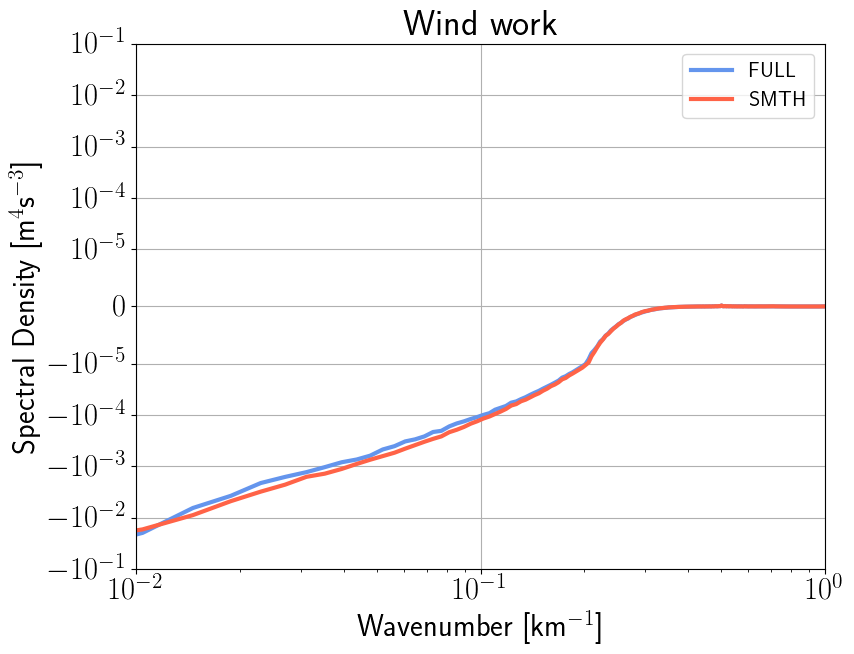

In [25]:
plt.figure(figsize=(9,7))

plt.plot(WWf.freq_r/dxx,(WWf.mean(axis=0))/dxx*1e3,label='FULL',linewidth=3,color='cornflowerblue')
plt.plot(WWt.freq_r/dxx,(WWt.mean(axis=0))/dxx*1e3,label='SMTH',linewidth=3,color='tomato')


plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=1e-5)
plt.xscale('log') 

plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')

plt.title('Wind work')
plt.xlim(1/100,1)
plt.ylim(-1e-1,1e-1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/windwork_spectral.png')


### Ogives computation

In [17]:
dz=np.abs(np.diff(eke_full.z_rho_psi).mean())
#KE

KAf=ogive(eke_full.freq_r/dxx*1e3,(eke_full.sum(['z_rho_psi'])*dz).mean('ocean_time')/dxx*1e3) #in metersss
Kxa=eke_full.freq_r/dxx #in Kilometers
KAt=ogive(eke_smth.freq_r/dxx*1e3,(eke_smth.sum(['z_rho_psi'])*dz).mean('ocean_time')/dxx*1e3) #in metersss


#PE
Kbf=ogive(epe_full_new.freq_r/dxx*1e3,(epe_full_new.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss
Kxb=epe_full_new.freq_r/dxx #in Kilometers
Kbt=ogive(epe_smth_new.freq_r/dxx*1e3,(epe_smth_new.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3)#in metersss


#wind work
WWpf=ogive(WWf.freq_r/dxx*1e3,np.nanmean(WWf,axis=0)/dxx*1e3) #in metersss
Kxw=WWf.freq_r/dxx #in Kilometers
WWpt=ogive(WWt.freq_r/dxx*1e3,np.nanmean(WWt,axis=0)/dxx*1e3)#in metersss

#wb

Kwbf=ogive(wb_full.freq_r/dxx*1e3,(wb_full.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3) #in metersss
Kxwb=wb_full.freq_r/dxx #in Kilometers
Kwbt=ogive(wb_smth.freq_r/dxx*1e3,(wb_smth.sum(['z_rho'])*dz).mean('ocean_time')/dxx*1e3)#in metersss




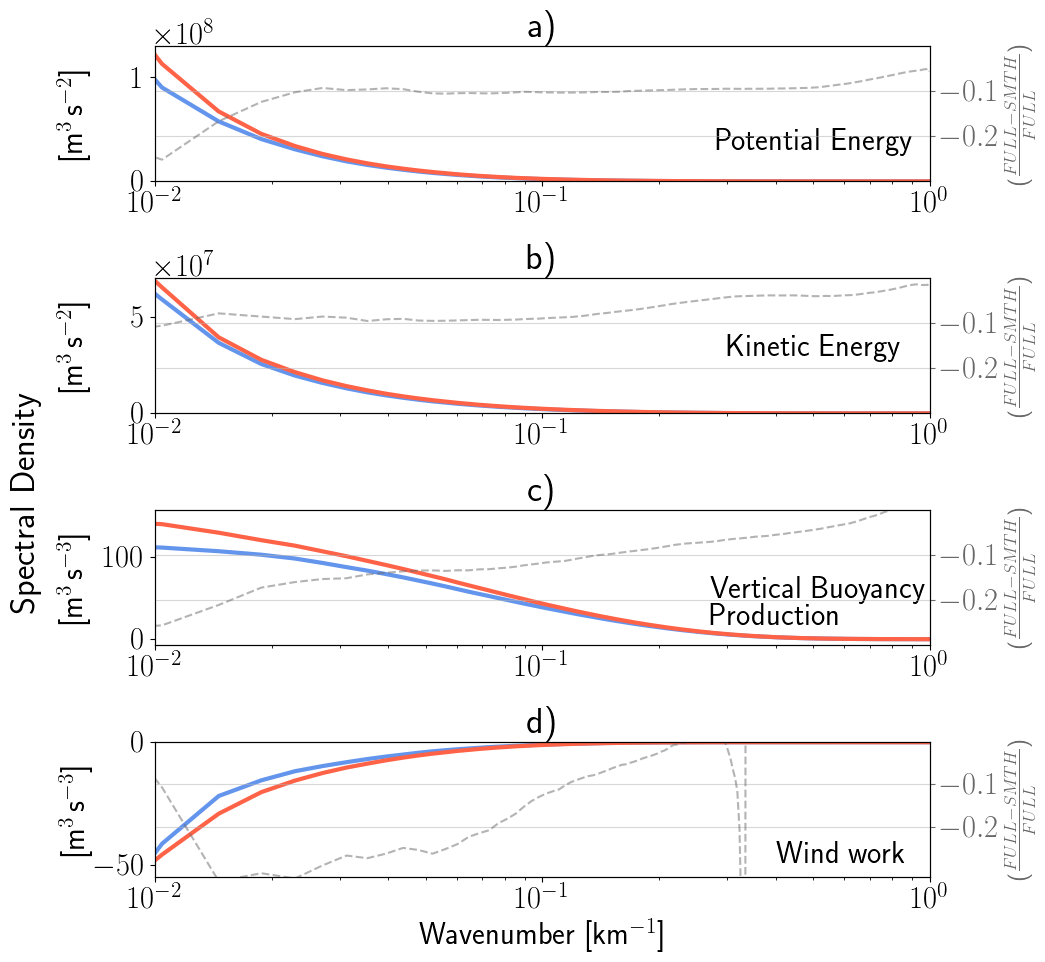

In [45]:
fig = plt.figure(figsize=(10,12))
gs1 = gridspec.GridSpec(40,20)

ax1 = fig.add_subplot(gs1[0:6,:])

ax1.plot(Kxb,Kbf,label='FULL',linewidth=3,color='cornflowerblue')
ax1.plot(Kxb,Kbt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('PE',fontsize=25,fontweight='bold')
ax1.text(2.8e-1,0.3e8,'Potential Energy')
ax1.set_xscale('log')
# ax1.set_yscale('log')

ax1.set_title('a)',fontweight='bold')
ax1.set_ylim(0,1.3e8)


# ax1.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
ax1.set_ylabel(r'[m$^{3}\,$s$^{-2}$]',fontweight='bold',labelpad=30)
ax1.set_xlim(1e-2,1)
# ax1.set_ylim(-1e-1,3e6)


# ax.legend()

ax12=ax1.twinx()
# ax12.plot((Kxb),((Kbf)/(Kbt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax12.plot((Kxb),((Kbf-Kbt)/(Kbf)),alpha=0.5,linestyle='dashed',color='dimgray')

ax12.set_ylabel(r'($\frac{FULL-SMTH}{FULL}$)',fontsize=18,color='dimgray')
ax12.set_xscale('log')
ax12.set_yticks([-0.2,-0.1])
ax12.set_ylim(-0.30,0)
ax12.grid(alpha=0.5)
ax12.tick_params(axis='y', colors='dimgray')
            
               
ax2 = fig.add_subplot(gs1[10:16,:])


ax2.plot((Kxa),KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax2.plot((Kxa),KAt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('KE (Ogive)',fontsize=15,fontweight='bold')
ax2.set_title('b)',fontweight='bold')

ax2.set_xscale('log')

ax2.text(3e-1,0.3e8,'Kinetic Energy')



# ax2.set_xlabel(r'Wavenumber [km$^{-1}$]',fontweight='bold')
ax2.set_ylabel(r'[m$^3\,$s$^{-2}$]',fontweight='bold',labelpad=30)
# ax.set_title(r'KE',fontsize=25)
ax2.set_xlim(1e-2,1)
ax2.set_ylim(-0.1,0.7e8)

ax22=ax2.twinx()
# ax2.plot((Kxa),((KAf)/(KAt)-1)*100,alpha=0.5,linestyle='dashed',color='cadetblue')
# ax22.plot((Kxa),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax22.plot((Kxa),((KAf-KAt)/(KAf)),alpha=0.5,linestyle='dashed',color='dimgray')

ax22.set_ylim(0.901,1)



ax22.set_ylabel(r'($\frac{FULL-SMTH}{FULL}$)',fontweight='bold',fontsize=18,color='dimgray')
ax22.set_xscale('log')
ax22.set_yticks([-0.2,-0.1])
ax22.set_ylim(-0.30,0)
ax22.grid(alpha=0.5)
ax22.tick_params(axis='y', colors='dimgray')




ax3 = fig.add_subplot(gs1[20:26,:])


ax3.plot(Kxwb,Kwbf,label='FULL',linewidth=3,color='cornflowerblue')
ax3.plot(Kxwb,Kwbt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title(r'$\int^{z=100}_{z=0}$ $wb$ $dz$',fontweight='bold')
ax3.set_title('c)',fontweight='bold')




ax3.set_xscale('log')

# ax3.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
ax3.set_ylabel(r'[m$^3\,$s$^{-3}$]',fontweight='bold',labelpad=10)
ax3.set_xlim(1e-2,1)
# ax.set_ylim(-1e-11,4e-11)

# yticks=np.arange(Kwbt.min(),Kwbt.max(),1e5)
# yticklabel=np.int_(yticks/1e5)
# ax3.set_yticks(yticks)
# ax3.set_yticklabels(yticklabel)

# ax3.text(1e-2,(yticks[-1]+0.5e5),r'$\times$10$^{5}$')
# ax3.text(3e-1,75,r'(100m-Integrated)',fontsize=25)
ax3.text(2.7e-1,50,r'Vertical Buoyancy')
ax3.text(2.7e-1,18,r'Production')



ax32=ax3.twinx()
ax32.plot((Kxwb),((Kwbf-Kwbt)/(Kwbf)),alpha=0.5,linestyle='dashed',color='dimgray')
ax32.set_ylabel(r'($\frac{FULL - SMTH }{FULL}$)',fontsize=18,color='dimgray')
ax32.set_xscale('log')
ax32.set_yticks([-0.2,-0.1])
ax32.set_ylim(-0.30,0)
ax32.grid(alpha=0.5)
ax32.tick_params(axis='y', colors='dimgray')



ax4 = fig.add_subplot(gs1[30:36,:])



ax4.plot(Kxw,WWpf,label='FULL',linewidth=3,color='cornflowerblue')
ax4.plot(Kxw,WWpt,label='SMTH',linewidth=3,color='tomato')

ax4.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# ax.set_ylabel(r'Spectral Density [m$^3\,$s$^{-3}$]',fontweight='bold')
ax4.set_ylabel(r'[m$^3\,$s$^{-3}$]',fontweight='bold',labelpad=1)

ax4.set_title('d)',fontweight='bold')


# ax.set_title(r'$F_{KE}$',fontsize=25,fontweight='bold')
ax4.text(4e-1,-49,'Wind work')

ax4.set_xscale('log')

# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax4.set_ylim(-55,0.1)
ax4.set_xlim(1e-2,1)
# ax.legend(loc=4)
decx=1
ax42=ax4.twinx()
# ax2.plot(Kxw[::decx],(np.abs(WWpf)/np.abs(WWpt))[::decx],alpha=0.5,linestyle='dashed',color='slategrey')

# ax42.plot(Kxw[::decx],(WWpf)/(WWpt)[::decx],alpha=0.5,linestyle='dashed',color='slategrey')
ax42.plot(Kxw,(WWpf-WWpt)/(WWpf),alpha=0.5,linestyle='dashed',color='dimgray')


ax42.set_ylabel(r'($\frac{FULL- SMTH}{FULL}$)',fontsize=18,color='dimgray')
# ax2.set_ylim(0.79,1)
ax42.set_xscale('log')
ax42.set_yticks([-0.2,-0.1])
ax42.set_ylim(-0.32,0)
ax42.grid(alpha=0.5)
ax42.tick_params(axis='y', colors='dimgray')

plt.tight_layout()

fig.supylabel('Spectral Density',fontsize=25,x=-0.02)
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/SUPER_PANEL_final_negative_differences.png',dpi=300,bbox_inches='tight')
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/SUPER_PANEL_final_loglog.png',dpi=300,bbox_inches='tight')

